In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import OneHotEncoder

from joblib import dump,load
#%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import  make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import random
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor

In [2]:
onehot = pd.read_csv("zomato.csv")
onehot.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [3]:
onehot.shape

(51717, 17)

In [4]:
# check for duplicate values
print("No of Duplicates in dataset:  ",onehot.duplicated().sum())
# drop the duplicates
onehot.drop_duplicates(inplace=True)

No of Duplicates in dataset:   0


In [5]:
# check for duplicate values
print("No of Duplicates in dataset:  ",onehot.duplicated().sum())

No of Duplicates in dataset:   0


This time we will drop all Null values. Last time we saved some Null values by converting them to relative values. But in this run we will neglect all values null. Initially there are 51k values by removing NULL it will be somewhere around 23k. Frankly speaking 23k is also good enough points to experiment.



In [6]:
onehot['rate'] = onehot['rate'].replace('NEW',np.NaN) # replace 'NEW' values with NaN
onehot['rate'] = onehot['rate'].replace('-',np.NaN) # replace '-' value with NaN
onehot.dropna(how = 'any', inplace = True) # remove all NaN

onehot['rate'] = onehot.loc[:,'rate'].replace('[ ]','',regex = True) # replace [] with '' string
onehot['rate'] = onehot['rate'].astype(str) # convert to string
onehot['rate'] = onehot['rate'].apply(lambda r: r.replace('/5','')) # replace '/5' character with '' string
onehot['rate'] = onehot['rate'].apply(lambda r: float(r)) # convert string back to float

In [7]:
onehot.shape

(23046, 17)

In [8]:
# removed ',' between two words; then converted to categorical features

onehot['cuisines'] = onehot['cuisines'].str.replace(',' , '') # replace ',' with '' string
onehot['cuisines'] = onehot['cuisines'].astype(str).apply(lambda x: ' '.join(sorted(x.split()))) # add white space
onehot['cuisines'].unique() # find unique values

array(['Chinese Indian Mughlai North', 'Chinese Indian North Thai',
       'Cafe Italian Mexican', ...,
       'BBQ Continental Indian Italian North', 'Nepalese Tibetan',
       'Andhra Biryani Hyderabadi'], dtype=object)

In [9]:
# removed ',' between two words; then converted to categorical features

onehot['rest_type'] = onehot['rest_type'].str.replace(',' , '') 
onehot['rest_type'] = onehot['rest_type'].astype(str).apply(lambda x: ' '.join(sorted(x.split())))
onehot['rest_type'].value_counts().head()

Casual Dining        7298
Bites Quick          5224
Cafe                 2321
Bar Casual Dining    1308
Dessert Parlor       1074
Name: rest_type, dtype: int64

In [10]:
# removed ',' between two words; then converted to categorical features

onehot['dish_liked'] = onehot['dish_liked'].str.replace(',' , '') 
onehot['dish_liked'] = onehot['dish_liked'].astype(str).apply(lambda x: ' '.join(sorted(x.split())))
onehot['dish_liked'].value_counts().head()

Biryani            179
Friendly Staff      68
Waffles             67
Biryani Chicken     66
Dosa Masala         56
Name: dish_liked, dtype: int64

In [11]:
# removed ',' between two words; then converted string to int value

onehot['approx_cost(for two people)'] = onehot['approx_cost(for two people)'].str.replace(',' , '') 
onehot.rename(columns={'approx_cost(for two people)': 'average_cost'}, inplace=True)

In [12]:
x = onehot.drop(['rate','name'],axis = 1)
y = onehot['rate']

In [13]:
train_data,test_data,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 33)

In [14]:
"""dump(train_data, 'train_data')
dump(test_data, 'test_data')
dump(y_train, 'y_train')
dump(y_test, 'y_test')"""

"dump(train_data, 'train_data')\ndump(test_data, 'test_data')\ndump(y_train, 'y_train')\ndump(y_test, 'y_test')"

In [15]:
train_data.shape

(16132, 15)

In [16]:
test_data.shape

(6914, 15)

In [17]:
train_data = load('train_data')
test_data = load('test_data')
y_train = load('y_train')
y_test = load('y_test')

In [18]:
all_features =[]

## One Hot Encoding

In [19]:
enc = OneHotEncoder( handle_unknown='ignore')

In [20]:
## ALWAYS AVOID DATA LEAKAGE

# this method is for training data set
def one_hot_fit_transform(df,name):
    output_data = df[name].values.reshape(-1, 1)
    return enc.fit_transform(output_data).toarray(), enc.get_feature_names([name])

# this method is for test data set
def one_hot_transform(df,name):
    output_data1 = df[name].values.reshape(-1, 1)
    return enc.transform(output_data1).toarray()

In [21]:
tr_dummy_rest_type,rest_tr = one_hot_fit_transform(train_data,'rest_type' )
te_dummy_rest_type = one_hot_transform(test_data,'rest_type' )
all_features.extend(rest_tr)


tr_dummy_online_order, oo_tr = one_hot_fit_transform(train_data,'online_order' )
te_dummy_online_order = one_hot_transform(test_data,'online_order' )
all_features.extend(oo_tr)

tr_dummy_book_table,bt_tr = one_hot_fit_transform(train_data,'book_table' )
te_dummy_book_table = one_hot_transform(test_data,'book_table' )
all_features.extend(bt_tr)

tr_dummy_city,loc_tr = one_hot_fit_transform(train_data,'location' )
te_dummy_city = one_hot_transform(test_data,'location')
all_features.extend(loc_tr)

tr_dummy_cuisines,cui_tr = one_hot_fit_transform(train_data,'cuisines' )
te_dummy_cuisines =one_hot_transform(test_data,'cuisines')
all_features.extend(cui_tr)

tr_dummy_dishliked,dish_tr = one_hot_fit_transform(train_data,'dish_liked' )
te_dummy_dishliked=one_hot_transform(test_data,'dish_liked')
all_features.extend(dish_tr)

In [22]:
len(all_features)

5831

In [23]:
tr_dummy_rest_type.shape, te_dummy_rest_type.shape

((16132, 52), (6914, 52))

In [24]:
tr_dummy_online_order.shape, te_dummy_online_order.shape

((16132, 2), (6914, 2))

In [25]:
tr_dummy_book_table.shape, te_dummy_book_table.shape

((16132, 2), (6914, 2))

In [26]:
tr_dummy_city.shape, te_dummy_city.shape

((16132, 88), (6914, 88))

In [27]:
tr_dummy_cuisines.shape, te_dummy_cuisines.shape

((16132, 1254), (6914, 1254))

In [28]:
tr_dummy_dishliked.shape, te_dummy_dishliked.shape

((16132, 4433), (6914, 4433))

In [29]:
type(tr_dummy_dishliked)

numpy.ndarray

In [30]:
type(train_data)

pandas.core.frame.DataFrame

In [31]:
## merge all training features

tr =pd.DataFrame(pd.np.column_stack([tr_dummy_rest_type, tr_dummy_online_order,tr_dummy_book_table ,tr_dummy_city,
                                 tr_dummy_cuisines,tr_dummy_dishliked]), columns=all_features)
## https://stackoverflow.com/questions/45963799/pandas-concat-resulting-in-nan-rows

l1=train_data.values.tolist()
l2=tr.values.tolist()

for i in range(len(l1)):
    l1[i].extend(l2[i])

X_train=pd.DataFrame(l1,columns=train_data.columns.tolist()+tr.columns.tolist())

In [32]:
X_train.shape

(16132, 5846)

In [33]:

## merge all testing features

te =pd.DataFrame(pd.np.column_stack([te_dummy_rest_type, te_dummy_online_order,te_dummy_book_table,te_dummy_city,
                                          te_dummy_cuisines,te_dummy_dishliked]),columns=all_features)


# X_test =pd.concat([test_data,te],axis=1)

l3=test_data.values.tolist()
l4=te.values.tolist()
for i in range(len(l3)):
    l3[i].extend(l4[i])

X_test=pd.DataFrame(l3,columns=test_data.columns.tolist()+te.columns.tolist())
X_test.shape

(6914, 5846)

In [34]:
X_train.drop(columns=['rest_type','location','cuisines','dish_liked','menu_item','url','phone','reviews_list','listed_in(type)','listed_in(city)','address','online_order','book_table'], inplace=True)

In [35]:
X_test.drop(columns=['rest_type','location','cuisines','dish_liked','menu_item','url','phone','reviews_list','listed_in(type)','listed_in(city)','address','online_order','book_table'],axis=1 , inplace=True)

In [36]:
X_train.head(2)

,votes,average_cost,rest_type_Bakery,rest_type_Bakery Bites Quick,rest_type_Bakery Cafe,rest_type_Bakery Dessert Parlor,rest_type_Bar,rest_type_Bar Bites Quick,rest_type_Bar Cafe,rest_type_Bar Casual Dining,...,dish_liked_Sandwiches Tea,dish_liked_Shakes Thick,dish_liked_Shawarma,dish_liked_Tea,dish_liked_Thali,dish_liked_Thali Veg,dish_liked_Tikka,dish_liked_Vada,dish_liked_Vegetarian,dish_liked_Waffles
0,326,500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,33,300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X_train.shape

(16132, 5833)

In [38]:
X_test.shape

(6914, 5833)

In [39]:
"""dump(X_train, 'one_hot_X_train')
dump(X_test, 'one_hot_X_test')
dump(y_train, 'one_hot_y_train')
dump(y_test, 'one_hot_y_test')"""

"dump(X_train, 'one_hot_X_train')\ndump(X_test, 'one_hot_X_test')\ndump(y_train, 'one_hot_y_train')\ndump(y_test, 'one_hot_y_test')"

In [40]:
X_train.shape, y_train.shape

((16132, 5833), (16132,))

In [41]:
X_test.shape, y_test.shape

((6914, 5833), (6914,))

## Random model

In [42]:
from sklearn.metrics import  make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [43]:
def mse(y, y_pred):
    return np.mean((y_pred - y)**2) 

mse_scorer = make_scorer(mse, greater_is_better=False)

In [44]:
import random

rand_pred= np.zeros(y_test.shape[0])
for i in range(y_test.shape[0]):
    rand_probs = round(random.uniform(1.0, 5.0),2)
    rand_pred[i] = rand_probs

mse(y_test, rand_pred)

2.316846326294468

## Model -1 Linear Regression

In [45]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

mse(y_test, y_pred_lr)

35484678456.80257

## Model - 2 SGD Regression Model

In [46]:
sgdReg = linear_model.SGDRegressor()
sgdReg.fit(X_train,y_train)
y_pred_sgdr = sgdReg.predict(X_test)

mse(y_test, y_pred_sgdr)

1.1001592766321332e+29

## Model - 3 Random Forest Regressor Model

In [47]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)

mse(y_test, y_pred_rfr)

0.014272063383860629

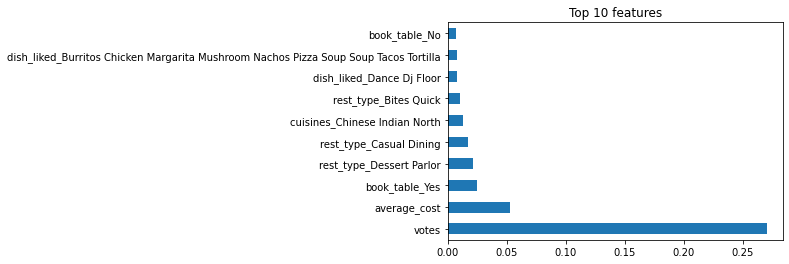

In [48]:
base_imp = pd.Series(rfr.feature_importances_, index=X_train.columns)
base_imp.nlargest(10).plot(kind='barh')
plt.title("Top 10 features")
plt.show()

In [49]:
Randpred = pd.DataFrame({ "actual": y_test, "pred": y_pred_rfr })
Randpred

,actual,pred
35957,4.0,4.000
4975,4.0,3.996
21830,3.9,3.889
11982,3.7,3.704
2597,3.8,3.849
...,...,...
19450,4.1,4.100
32469,3.5,3.522
3181,4.0,3.903
3029,4.1,4.117


### Observation:
- This is brilliant, last we saw MSE = 0.0142, without hyperparam tuning.

## Hyperparam Tuning for RFR One Hot Encoding

In [50]:
"""tuned_parameters = {'n_estimators': [250,500,1000,1200]}

grd_regressor = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=10, 
                   n_jobs=-1, verbose=1, scoring=mse_scorer)
grd_regressor.fit(X_train, y_train)"""

"tuned_parameters = {'n_estimators': [250,500,1000,1200]}\n\ngrd_regressor = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=10, \n                   n_jobs=-1, verbose=1, scoring=mse_scorer)\ngrd_regressor.fit(X_train, y_train)"

After above experiment we got below result

- MSE: 0.014044408085530756 == 200 (n_estimators)
- MSE: 0.014195859400387666 ==250 (n_estimators)
- MSE: 0.014120113806332284 == 500 (n_estimators)
- MSE: 0.014103516544483965 ===1000 (n_estimators)
- MSE: 0.014083536144839625 ===1200 (n_estimators)

We can clearly see that MSE values is dropping but fact is to run 1200 estimators it take more than 4.5 hours on my system(i5 7Gen, 16GB RAM), to run 1000 n_estimators is took almost 3 hours.

So we can reduce MSE value further but training time is increases accordingly so I decide to stop on this experiments.

Final n_estimators choose 300.

In [51]:
rfr = RandomForestRegressor(n_estimators =300)
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)

mse(y_test, y_pred_rfr)

0.014070552337551383